# Commonsense (AI2 Reasoning Challenge)

In [ ]:
import numpy as np
from datasets import load_dataset
import tqdm
from torch.utils.data import DataLoader
import sys
import pickle as pkl
sys.path.append("../")

from train import train_ensemble


hf_token = ""

In [2]:
ds_names = ["arc_challenge"]

In [3]:
all_model_data = {
    "meta-llama__Llama-2-70b-chat-hf": {},
    "mistralai__Mixtral-8x7B-Instruct-v0.1" : {},
    "google__gemma-7b": {},
    "microsoft__phi-2": {},
    "mistralai__Mistral-7B-v0.1": {},
}

model_names = list(all_model_data.keys())

In [8]:
def load_data(model_name, ds_name):
    data = load_dataset(
    f"HuggingFaceEvalInternal/{model_name}-details-private",
    name=f"{model_name}__leaderboard_{ds_name}",
    split="latest",
    token=hf_token)

    
    data_len = len(data)
    remove_idx = [idx for idx in range(len(data)) if np.array(data["resps"][idx]).shape[0] != 4 or data["doc"][idx]["answerKey"] not in ["A", "B", "C", "D"]]

    doc_ids = [data["doc_id"][idx] for idx in range(data_len) if idx not in remove_idx]
    resps = [data["resps"][idx] for idx in range(data_len) if idx not in remove_idx]
    labels = [data["doc"][idx]["answerKey"] for idx in range(data_len) if idx not in remove_idx]
    idx = np.argsort(doc_ids)

    probs = np.array(resps).squeeze()[:, :, 0].astype(float)
    labels = np.array(labels)
    choices = sorted(list(set(labels)))
    labels_list = [choices.index(lbl) for lbl in labels]
    label_arr = np.array(labels_list).astype(int)

    return probs[idx], label_arr[idx]

for mn in list(all_model_data.keys()):
    print(mn)
    for ds_name in tqdm.tqdm(ds_names):
        x, y = load_data(mn, ds_name)
        all_model_data[mn][ds_name] = {
            "data" : x,
            "label": y
        }

with open("commonsense_data.pkl", "wb") as f:
    pkl.dump(all_model_data, f)

meta-llama__Llama-2-70b-chat-hf


100%|██████████| 1/1 [01:05<00:00, 65.59s/it]


mistralai__Mixtral-8x7B-Instruct-v0.1


100%|██████████| 1/1 [00:58<00:00, 58.19s/it]


google__gemma-7b


100%|██████████| 1/1 [00:55<00:00, 55.62s/it]


microsoft__phi-2


100%|██████████| 1/1 [00:55<00:00, 55.71s/it]


mistralai__Mistral-7B-v0.1


100%|██████████| 1/1 [00:56<00:00, 56.30s/it]


In [4]:
with open("commonsense_data.pkl", "rb") as f:
    all_model_data = pkl.load(f)

In [5]:
model_names = list(all_model_data.keys())

In [6]:
ds_name = ds_names[0]
results = {}

results[ds_name] = {}
all_x, all_y = [], []
for mn in all_model_data.keys():
    x, y = all_model_data[mn][ds_name].values()
    all_x.append(x)
    all_y.append(y)
all_x = np.concatenate(all_x, axis=1)

try:
    for y_idx in all_y:
        for i in range(len(y_idx)):
            assert(y_idx[i] == y[i])
except AssertionError as e:
    print(e)
    print(f"skipping ... {ds_name}")

concat_data = np.concatenate([all_x, y[:, None]], axis=1)
rand_id = np.random.permutation(len(concat_data))
train_data = concat_data[rand_id]

train_size = int(len(x) * 0.75)
train_data, test_data = concat_data[:train_size], concat_data[train_size:]

val_size = int(len(train_data) * 0.25)
train_size = len(train_data) - val_size

novel_data = test_data[:, :-1]
novel_label = test_data[:, -1]
for i, novel_arr in enumerate(np.split(novel_data, len(model_names), axis=1)):
    pred = novel_arr.argmax(axis=1)
    acc = np.mean(novel_label == pred)
    print(f"{model_names[i]}: Acc: {acc:.4f}")
    results[ds_name][model_names[i]] = acc * 100


batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(train_data[train_size:], batch_size=batch_size, shuffle=True)
novel_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

space_size = all_x[0].shape[0] // len(model_names)

exp_result = train_ensemble(model_names, train_loader, val_loader, novel_loader,
                n_epochs=500, save_dir=".",
                space_size=space_size, verbose=False)
results[ds_name]["TOPLA"] = exp_result["test_acc"]
print(exp_result["test_acc"])


meta-llama__Llama-2-70b-chat-hf: Acc: 0.4895
mistralai__Mixtral-8x7B-Instruct-v0.1: Acc: 0.6329
google__gemma-7b: Acc: 0.5664
microsoft__phi-2: Acc: 0.5629
mistralai__Mistral-7B-v0.1: Acc: 0.5455


/home/stekin6/sft/inference_llm/other_results/../train.py:77: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Training ended, total time: 4.74
Novel Acc = 64.1875 +- 5.19
64.1875


In [55]:
avg_scores = {mn: 0 for mn in model_names}
avg_scores["TOPLA"] = 0
for ds_name, res in results.items():
    for mn, acc in res.items():
        avg_scores[mn] += acc

for mn in model_names:
    avg_scores[mn] = avg_scores[mn] / len(results.keys())
avg_scores["TOPLA"] /= len(results.keys())

In [56]:
avg_scores

{'mistralai__Mixtral-8x7B-Instruct-v0.1': 63.286713286713294,
 'google__gemma-7b': 56.64335664335665,
 'microsoft__phi-2': 56.29370629370629,
 'mistralai__Mistral-7B-v0.1': 54.54545454545454,
 'TOPLA': 63.604166666666664}

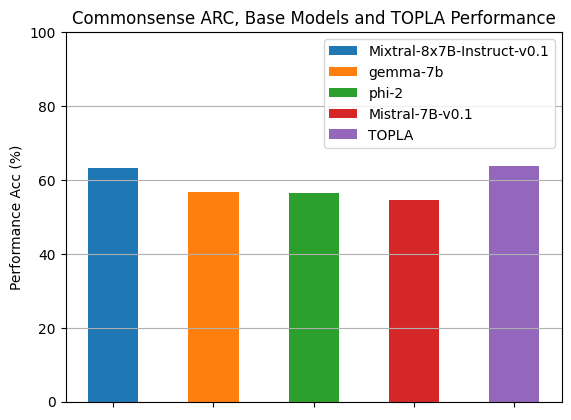

In [58]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

width = 0.5  # the width of the bars
multiplier = 0
mstrip_names = []
x = np.arange(len(avg_scores.keys()))
for i, (mn, acc) in enumerate(avg_scores.items()):
    strip_name = mn.split("__")
    strip_name = strip_name[1] if len(strip_name) == 2 else strip_name[0]
    offset = width * multiplier
    rects = ax.bar(x[i] + offset, acc, width, label=strip_name)
    # mstrip_names.append(strip_name)

ax.set_ylabel('Performance Acc (%)')
ax.set_title('Commonsense ARC, Base Models and TOPLA Performance')
ax.set_xticks(x, mstrip_names, rotation=10)
ax.legend(loc='upper right')
ax.set_ylim(0, 100)
ax.yaxis.grid(zorder=0)
plt.show()
